# Inject missingness into the (time-series) dataset
Insert missingness into a dataset and save the corresponding ground truth m_graph and missingness model parameters. 
We use an AFAAgent that is based on a propensity score model to model the desired missingness and sample from it. 

__Note__: Only suitable for fully observed datasets where we want to test what happens under missingness. If your dataset already has missingness, please run `preparation03_missingness_assumptions` instead to define what you know about the missing data process. 

### Define paths 

In [1]:
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for new missingness scenario 
miss_scenario  = 'MCAR_1'

In [2]:
# specifications of fully observed 
data_dir         = "../../../data/ts/" + dataset_name + "/fully_observed/" 
data_file          = data_dir + dataset_name + '_static.csv.gz' 
temporal_data_file = data_dir + dataset_name + '_ts_eav.csv.gz' 
superfeature_mapping_file = data_dir + 'superfeatures.csv'
problem_file   = data_dir + 'problem/' + 'problem.yaml'
afa_problem_files = {
        'action_file'          : data_dir + 'afa_problem/' + 'acquisition_actions.csv', 
        'prediction_cost_file' : data_dir + 'afa_problem/' + 'prediction_cost.csv'
                }
folds_file = data_dir + 'folds/' + 'fold_list.hkl'

# new specifications (created in this notebook) 
data_dir_new     = "../../../data/ts/"+ dataset_name +"/" + miss_scenario + '/' 
data_file_new    = data_dir_new + dataset_name +  '_' + miss_scenario +'.csv' 
m_graph_adj_file      = data_dir_new + '/' + 'm_graphs/'  + 'ground_truth/' + 'm_graph_adjacencies.csv'
ps_model_weights_file = data_dir_new + '/' + 'm_graphs/'  + 'ground_truth/' + 'weights.csv'

# reporting
explanation_file = data_dir  + '/' + 'reports/' + 'dataset_description_with_miss_ground_truth'

### Imports 

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

# navigate to afa directory 
sys.path.insert(0, os.path.abspath('../../afa'))

## Load dataset without missingness 
At first, we want to load the dataset

Includes loading: 
- superfeature mapping
- problem
- afa_problem 

In [4]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-02-05 21:17:50.037689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 21:17:50.192607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:17:50.192625: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 21:17:50.923383: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
data_loader = DataLoader_ts(    data_file                  = data_file,
                                temporal_data_file         = temporal_data_file,
                                superfeature_mapping_file  = superfeature_mapping_file,
                                problem_file               = problem_file, 
                                afa_problem_files          = afa_problem_files, 
                                folds_file                 = folds_file)

dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 819.50it/s]


## Define agent to induce missingness
Here we use an AFAMechanismAgent (which uses PropensityScoreModel). 
This requires defining:
- an m_graph (through an adjacency matrix) 
- weights for a logistic regression model / constant model that defines the propensity score 

### Define missing data_graph and ps_model weights

#### Option 1: Create corresponding files directly as .csv file
__m-graph__:  
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: name of the features and then name of the superR
- entry(i,j) = 1  
    if node of index i has an arrow to node of column j 
    
__ps_model_weights__: 
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: 
    - row 1: bias 
    - other rows: names of the parents 
        - entry(i,j) = 1  
            linear weight of parent on superR

In [6]:
dataset.temporal_data

variable,id,time,X0_ts,X1_ts,X2_ts,X3_ts,Y_ts
0,0,0,0.040214,0.736119,0.903988,-0.271101,0.0
1,0,1,-0.492273,-0.268303,-0.921176,-0.812881,1.0
2,0,2,0.309823,-0.386123,1.315453,-0.241455,0.0
3,0,3,1.871679,0.845866,1.473744,0.437033,0.0
4,0,4,1.224608,0.097955,0.098419,-0.635451,0.0
...,...,...,...,...,...,...,...
995,99,5,0.346083,0.991062,-0.432751,1.140907,0.0
996,99,6,-1.823515,0.312444,0.004809,0.671610,0.0
997,99,7,0.035619,-0.076120,-0.245551,0.130265,0.0
998,99,8,0.850422,1.200439,0.028020,-1.400394,0.0


In [7]:
dataset.feature_name

{'temporal': ['X0_ts', 'X1_ts', 'X2_ts', 'X3_ts'],
 'data': ['X0', 'X1', 'Y'],
 'treatment': None,
 'label': ['Y_ts'],
 'super_data': ['superX0', 'superY'],
 'super_temporal': ['superX0_ts', 'superX1_ts', 'superX2_ts']}

#### Option 2: Define here and save
Define the adjacency matrix of the m_graph and the weights using a pandas df

In [8]:
from afa.data_modelling.missingness.missing_data_graph.utils import save_m_graph_adjacency_matrix
import pandas as pd
# missing data graph
m_graph_adj = pd.DataFrame( [[0, 0], [0, 0]], 
                            index=['X0_ts', 'X1_ts' ], 
                            columns=['R_superX1_ts', 'R_superX2_ts'])

save_m_graph_adjacency_matrix( m_graph_adj , m_graph_adj_file = m_graph_adj_file  )  
m_graph_adj

,R_superX1_ts,R_superX2_ts
X0_ts,0,0
X1_ts,0,0


In [9]:
from afa.data_modelling.missingness.propensity_scores.utils import save_logistic_regression_ps_model_weights, load_logistic_regression_ps_model_weights
import numpy as np 
# weights for ps model 
weights_df  = pd.DataFrame([[0.9, 0.95],[np.nan, np.nan],[np.nan, np.nan]], 
                        index   = ['bias', 'X0_ts',  'X1_ts'], 
                        columns = ['R_superX1_ts', 'R_superX2_ts'])
save_logistic_regression_ps_model_weights(weights_df = weights_df,ps_model_weights_file = ps_model_weights_file) 
weights_df

,R_superX1_ts,R_superX2_ts
bias,0.9,0.95
X0_ts,NaN,NaN
X1_ts,NaN,NaN


#### Option 3 (not recommended): Prepared m_graphs and weights 
Lastly, for specific datasets, the creation can be automatically stored using hard-coded specifications. 

In [1]:
from configurations.data_settings.define_data_settings_ts import generate_m_graphs_and_weights_ts
m_graph_adj, weights_df = generate_m_graphs_and_weights_ts( dataset_name , miss_scenario ,  data_dir = data_dir_new  )

ModuleNotFoundError: No module named 'configurations'

### Initialize a Agent (using PropensityScoreModel)

In [11]:
from afa.data_modelling.missingness.missing_data_graph.utils import load_m_graph_adjacency_matrix
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_ts import MissingDataGraph_ts
from afa.data_modelling.models.temporal_models.joint_models.utils import load_joint_model_weights_ts
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_ts import PropensityScoreModel_ts
from afa_models.afa_agents.afa_mechanism_agents.afa_mechanism_agent import AFAMechanismAgent

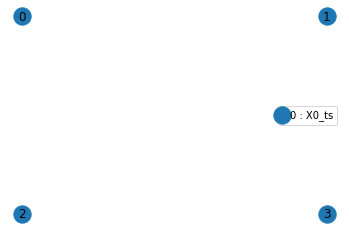

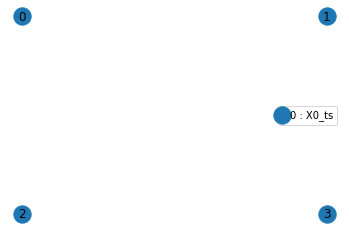

In [12]:
# 1. load m_graph 
m_graph_adj = load_m_graph_adjacency_matrix( m_graph_adj_file = m_graph_adj_file )
m_graph     = MissingDataGraph_ts(   m_graph_adj  = m_graph_adj ) 

# visualize
m_graph.plot() 

In [13]:
# 2. load weights
weights_df = load_logistic_regression_ps_model_weights( ps_model_weights_file = ps_model_weights_file) 

# 3. initialize params
ps_model_params = {}
ps_model_params['base_model_params'] = {  'base_model_type': 'stationary_constant',
                                          'gt_weights': weights_df}

# 4. init ps model
ps_model_name = 'ps_model_' + miss_scenario + '_gt'
ps_model = PropensityScoreModel_ts( name            =  ps_model_name, 
                                    m_graph         = m_graph, 
                                    feature_name    = dataset.feature_name,
                                    target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                    model_params = ps_model_params ) 

Change base_model to stationary_constant
Change base_model to stationary_constant
Set weight for constant stationary model ...
Set weight for constant stationary model ...


In [14]:
afa_agent = AFAMechanismAgent(  name    = miss_scenario + '_agent',
                                ps_model= ps_model 
                                 )

## Create new dataset using the defined agent

Run the agent as an afa agent over the dataset to create an afa_dataset. Then create a new regular dataset out of it

In [15]:
from afa_datasets.afa_dataset_ts import AFADataset_ts 

In [16]:
afa_results = afa_agent.predict(dataset, ids = None, fold = None, split = None,  n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_ts(  dataset = dataset, model = afa_agent, results = afa_results) 

# check retrieving data 
data, afa_results = afa_dataset.get_data( fold = None, split = None, n_samples = 1) 

In [17]:
dataset_new =  afa_dataset.create_new_dataset()

## Visualize newly created missingness 

In [18]:
dataset_new.temporal_data.isna().sum()

variable
id        0
time      0
X0_ts     0
X1_ts    92
X2_ts    61
X3_ts    61
Y_ts      0
dtype: int64

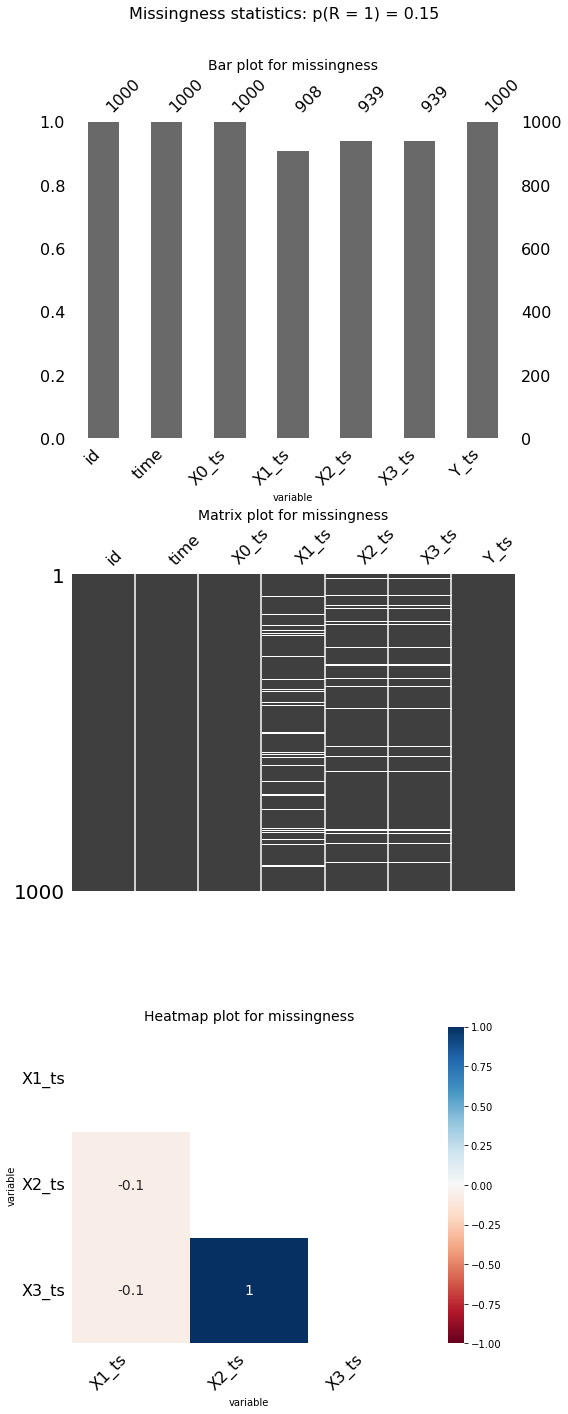

In [19]:
fig = dataset_new.plot_missingness_stats()

## Add the ground truth propensity score to the dataset

For comparison reasons we might be interested in the ground truth propensity score and add it back to dataset_new

In [20]:
from afa.data_modelling.missingness.missingness_model import MissingnessModel

In [21]:
# compute ps values
ps_values, ps_values_1 = ps_model.predict(dataset_new)

In [22]:
# init miss_model in dataset
miss_model = MissingnessModel(m_graph)
dataset_new.miss_model = miss_model 

In [23]:
# add to dataset
dataset_new.miss_model.add_ps_values( ps_model_name , 
                                      ps_values = ps_values, 
                                      ps_values_1 = ps_values_1 )

## Save the new dataset

In [24]:
dataset_new.save( data_dir = data_dir_new, 
                         dataset_name = dataset_name + '_' + miss_scenario,
                         save_folds = True) 

In [25]:
dataset_new.temporal_data[dataset_new.temporal_data['id'] == 36]

variable,id,time,X0_ts,X1_ts,X2_ts,X3_ts,Y_ts
360,36,0,-0.294428,1.098071,0.224244,1.010012,0.0
361,36,1,-0.925137,-0.533146,0.200127,0.907471,0.0
362,36,2,0.571811,-0.930963,NaN,NaN,0.0
363,36,3,0.965276,-0.121776,1.319633,-1.130943,0.0
364,36,4,-0.478296,NaN,-0.451901,-1.568209,1.0
365,36,5,1.004122,-0.380520,-0.361794,-1.242529,1.0
366,36,6,-1.248140,-0.507851,-0.270173,-0.141366,1.0
367,36,7,-0.074897,0.593147,-1.044999,-0.320685,0.0
368,36,8,-1.318609,-0.170743,NaN,NaN,1.0
369,36,9,0.018420,-0.074130,-0.644763,-0.627732,0.0


In [26]:
dataset_new.get_data(ids = [36])

{'feature': array([[0., 0., 0.]]),
 'label': array([[[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.]]]),
 'treatment': None,
 'temporal_feature': array([[[-0.29442754,  1.09807126,  0.22424365,  1.010012  ],
         [-0.92513675, -0.53314553,  0.20012698,  0.90747066],
         [ 0.57181103, -0.9309627 ,         nan,         nan],
         [ 0.96527645, -0.12177648,  1.31963288, -1.13094259],
         [-0.47829585,         nan, -0.45190112, -1.56820892],
         [ 1.00412199, -0.38051995, -0.36179443, -1.24252929],
         [-1.24814022, -0.50785071, -0.27017311, -0.14136596],
         [-0.07489741,  0.59314694, -1.04499929, -0.32068528],
         [-1.31860946, -0.17074322,         nan,         nan],
         [ 0.01841979, -0.07412961, -0.64476347, -0.62773176]]]),
 'time': array([[[0],
         [1],
         [2],
         [3],
         [4],
         [5],
         [6],
         [7],
         [

## Reporting: summarize the whole dataset (with missingness) 
Store information in reports folder in latex / markdown format.

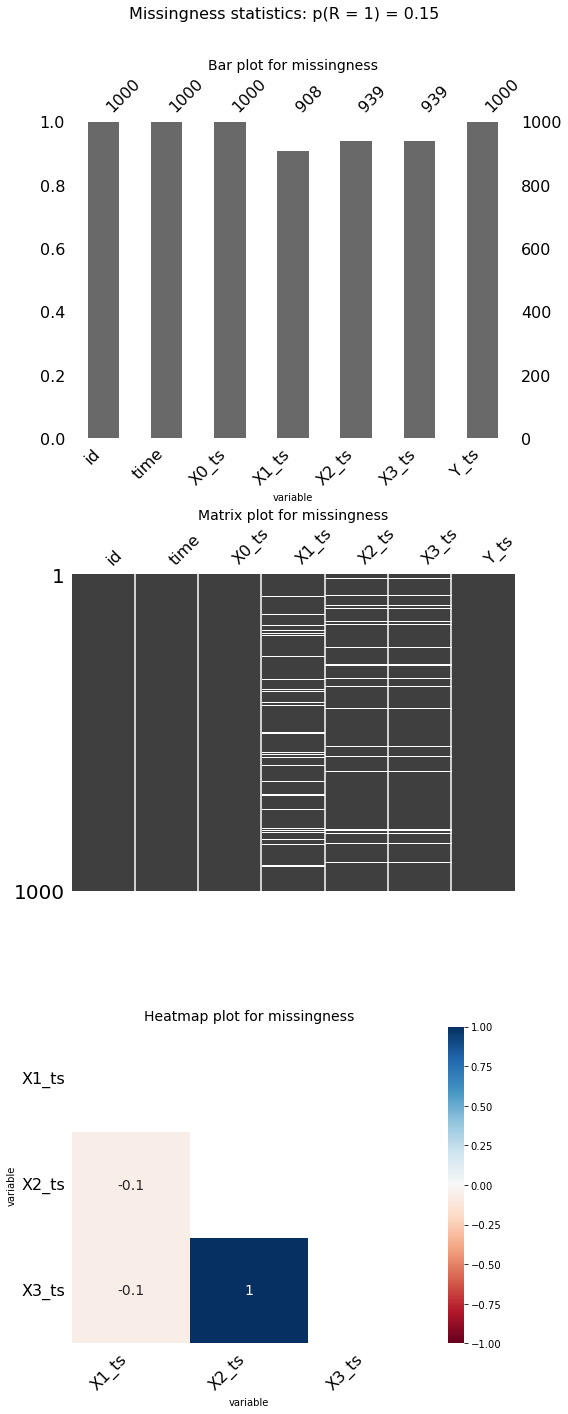

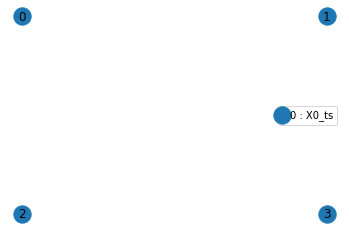

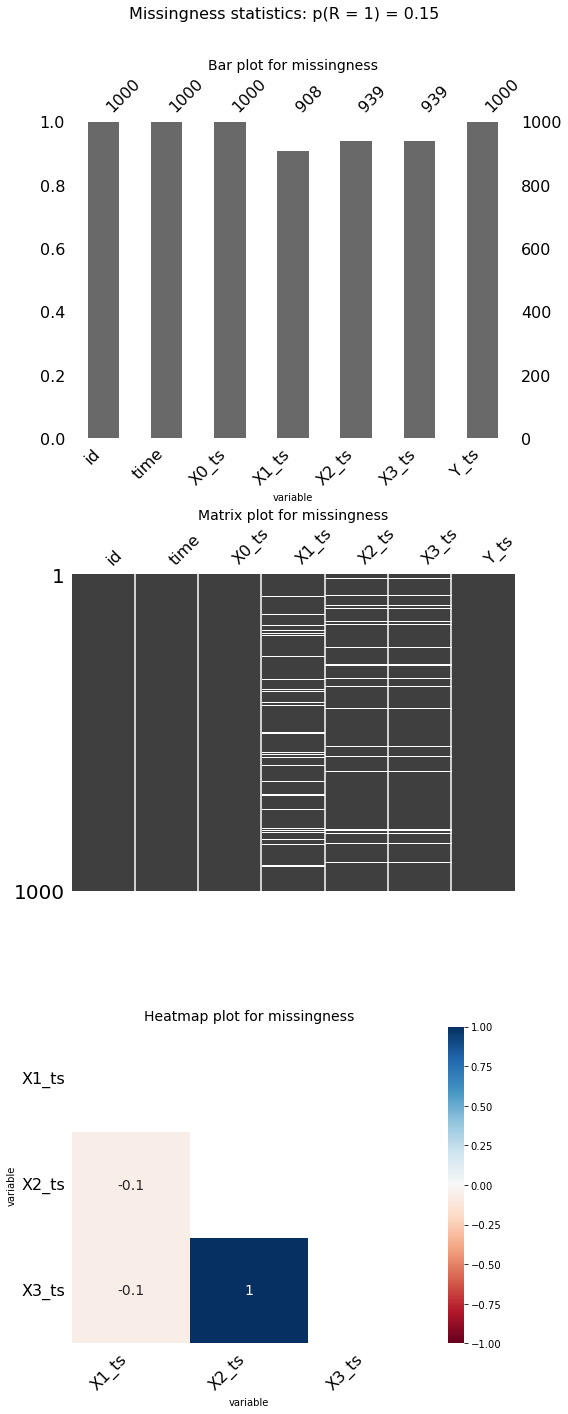

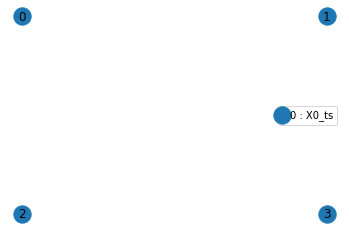

In [27]:
dataset_new.explain(file=  explanation_file + '.md', format = 'markdown')
dataset_new.explain(file=  explanation_file + '.tex', format = 'latex')